In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 

import astropy.units as u
from astropy.utils.data import download_file 
from astropy.io import fits #We use fits to open the actual data file

from astropy.utils import data
data.conf.remote_timeout = 60

from spectral_cube import SpectralCube 

from astroquery.esasky import ESASky
from astroquery.utils import TableList
from astropy.wcs import WCS
from reproject import reproject_interp

In [44]:
data = fits.open("NGC1487/ADP.2017-11-20T16:23:13.681.fits")
cube = SpectralCube.read(data[1])
data.close()

In [45]:
print (cube)

SpectralCube with shape=(3721, 323, 317) and unit=1e-20 erg / (Angstrom cm2 s):
 n_x:    317  type_x: RA---TAN  unit_x: deg    range:    58.918799 deg:   58.942565 deg
 n_y:    323  type_y: DEC--TAN  unit_y: deg    range:   -42.380882 deg:  -42.362993 deg
 n_s:   3721  type_s: AWAV      unit_s: Angstrom  range:     4700.043 Angstrom:    9350.043 Angstrom


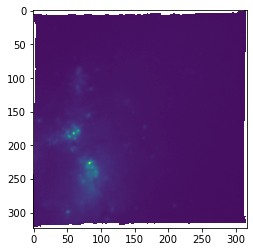

In [46]:
cube[300, :, :].quicklook() #slice the cube along the spectral azis, and display a quick image

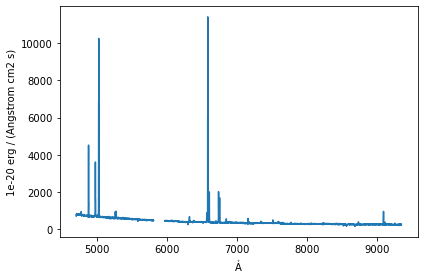

In [47]:
cube[:, 180, 60].quicklook() #extract a single spectrum through the data cube
plt.tight_layout()
plt.savefig("NGC1487_spectrum.jpg")

In [48]:
_, b, _ = cube.world[0, :, 0] #extract latitude world coordinates from cube
_, _, l = cube.world[0, 0, :] #extract longitude world coordinates from cube

In [49]:
#define desired latitude and longitude range
lat_range = [-42.380882, -42.362993]*u.deg
lon_range = [58.918799,58.942565]*u.deg 

#create a sub_cube cut to these coordinates (realmente usaremos el cubo completo)
sub_cube = cube.subcube(xlo=lon_range[0], xhi=lon_range[1], ylo=lat_range[0], yhi=lat_range[1], zlo=6530*u.AA, zhi=6630*u.AA )
# sub_cube

In [50]:
#sub_cube=cube

In [51]:
#print(sub_cube)

In [52]:
#sub_cube_slab = cube.spectral_slab(6500 *u.AA, 6800 *u.AA)
#print(sub_cube_slab)

In [53]:
#ha_cube = sub_cube_slab.with_spectral_unit(u.km/u.s, velocity_convention="optical", rest_value=6563*u.AA)
#ha_subcube = ha_cube.spectral_slab(-300*u.km/u.s, 300*u.km/u.s)

In [54]:
#moment map
moment_0 = sub_cube.with_spectral_unit(u.AA).moment(order=0) #zero-th moment
moment_1 = sub_cube.with_spectral_unit(u.km/u.s, velocity_convention="optical", rest_value=6563*u.AA).moment(order=1) #first moment

# write the moments as a FITS image
# moment_0.write('hi_moment_0.fits') 
# moment_1.write('hi_moment_1.fits')

print("moment_0 has units of: ", moment_0.unit)
print("moment_1 has units of: ", moment_1.unit)

continuo = moment_0 * 10**18 / (u.cm * u.cm) * u.s / u.K / u.km

moment_0 has units of:  1e-20 erg / (cm2 s)
moment_1 has units of:  km / s


/Users/belen/opt/anaconda3/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * pix_cen, axis=axis) /


In [55]:
#print(moment_1.wcs)

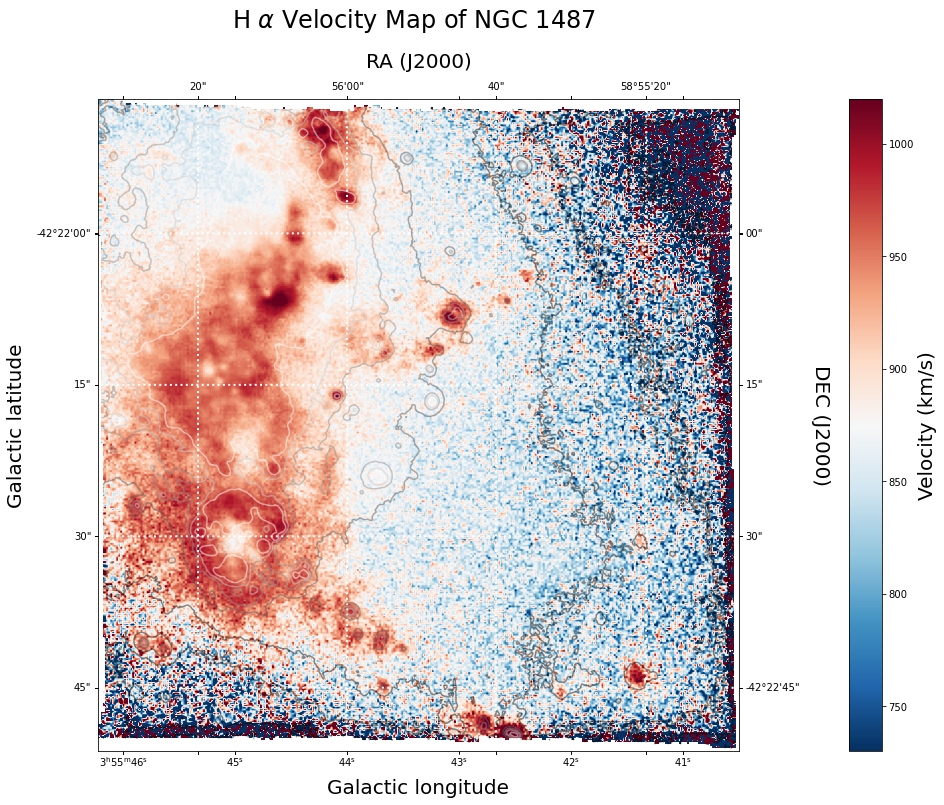

<Figure size 432x288 with 0 Axes>

In [62]:
# initiate a figure and axis objects with WCS projection information
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111, projection=moment_1.wcs)

# display the moment map image
im = ax.imshow(moment_1.hdu.data, cmap = "RdBu_r", vmin=730, vmax=1020)
#ax.invert_yaxis() flip the y axis

#add axes labels
ax.set_xlabel("Galactic longitude", fontsize = 20)
ax.set_ylabel("Galactic latitude", fontsize = 20)

#add a colorbar
cbar = plt.colorbar(im, pad=.11)
cbar.set_label("Velocity (km/s)", size=20)

#overlay set of RA/DEC axes
overlay = ax.get_coords_overlay("fk5")
overlay.grid(color="white", ls="dotted", lw=2)
overlay[0].set_axislabel("RA (J2000)", fontsize=20)
overlay[1].set_axislabel("DEC (J2000)", fontsize=20)

#overplot column density contours (CONTÍNUO ESTELAR)
levels = (1e20, 5e20, 1e21, 3e21, 5e21, 7e21, 1e22) #define contour level to use
ax.contour(continuo.hdu.data, cmap="Greys_r", alpha=0.5, levels=levels)
plt.title(r'H $\alpha$ Velocity Map of NGC 1487  ', fontsize=24, color='black', y=1.1)
plt.show()


plt.tight_layout()
plt.savefig("NGC1487_Halfa_velocity.jpg")




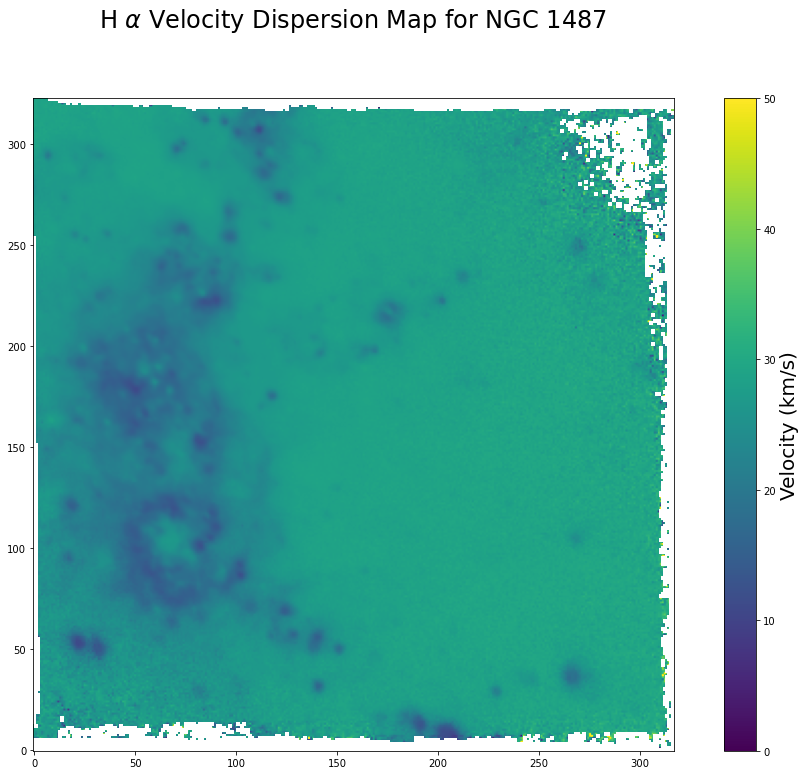

<Figure size 432x288 with 0 Axes>

In [58]:
sigma_map = sub_cube.linewidth_sigma()

# Visualiza los mapas con ajustes adicionales
plt.figure(figsize=(18, 12))
img = plt.imshow(sigma_map.value, cmap='viridis', origin='lower')

# Ajuste del rango en la barra de colores
clb = plt.colorbar(img, label="Velocity (km/s)")
img.set_clim(vmin=0, vmax=50)  # Reemplaza valor_minimo y valor_maximo con tus límites deseados

# Ajuste del tamaño de fuente de la barra de colores
clb.ax.yaxis.label.set_fontsize(20)  # Cambia el tamaño de fuente aquí (15 es un ejemplo)

plt.title(r'H $\alpha$ Velocity Dispersion Map for NGC 1487', fontsize=24, color="black", y=1.1)
plt.show()

plt.tight_layout()
plt.savefig("NGC1487_Halpha_sigmavelocity.jpg")
